In [1]:
from transformers import AutoModelForMaskedLM
from transformers import AutoTokenizer
import torch
from collections import Counter
import transformers
from transformers import pipeline
from datasets import load_dataset
from transformers import DataCollatorForLanguageModeling
from transformers import TrainingArguments
from transformers import Trainer
import math
from torch.utils.data import DataLoader
from transformers import default_data_collator
from torch.optim import AdamW
from accelerate import Accelerator
from transformers import get_scheduler
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import preprocessing
import pickle
import pandas as pd
import os
import re
import comprehension_model

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
data_files = {"train": "swerick_data_random_train.pkl", "test": "swerick_data_random_test.pkl"}
swerick_dataset = load_dataset("pandas",data_files=data_files)
print(swerick_dataset)

DatasetDict({
    train: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 12399
    })
    test: Dataset({
        features: ['protocole', 'texte'],
        num_rows: 2673
    })
})


In [4]:
model_checkpoint = "KBLab/bert-base-swedish-cased"
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [5]:
model_kb = preprocessing.create_model_MLM(model_checkpoint)
model_kb=model_kb.to(device)

Some weights of the model checkpoint at KBLab/bert-base-swedish-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
tokenizer =preprocessing.create_tokenizer(model_checkpoint)

In [ ]:
exbert_tokenizer = AutoTokenizer.from_pretrained("exbert_tokenizer")

In [ ]:
from transformers import PreTrainedTokenizerFast

swerick_tokenizer= PreTrainedTokenizerFast(
    tokenizer_file="/home/laurinemeier/swerick/alvis_project/pretraining_from_scratch/tokenizer_swerick.json",
    unk_token="[UNK]",
    pad_token="[PAD]",
    cls_token="[CLS]",
    sep_token="[SEP]",
    mask_token="[MASK]"
)

In [ ]:
with open("lm_dataset.pkl","rb") as f:
    lm_datasets= pickle.load(f)

In [ ]:
with open("valid_dataset.pkl","rb") as f:
    valid_dataset= pickle.load(f)

valid_dataset

In [ ]:
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
lm_dataset_bis = lm_datasets.remove_columns(["word_ids","token_type_ids"])

print(lm_dataset_bis["test"])
eval_dataset = preprocessing.create_deterministic_eval_dataset(lm_dataset_bis["test"],data_collator)
valid_dataset=preprocessing.create_deterministic_eval_dataset(valid_dataset,data_collator)

In [ ]:
from datasets import Dataset
valid_dataset=valid_dataset.remove_columns(["word_ids"])
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
small_valid_dataset = preprocessing.create_deterministic_eval_dataset(valid_dataset.select(range(10000)),data_collator)
small_valid_dataloader=preprocessing.create_dataloader(small_valid_dataset,64,default_data_collator)
                                                                      

In [ ]:
word = "Statsrådet"
token_id = tokenizer.convert_tokens_to_ids(word)

In [ ]:
def special_token(token,example):
    return token in example['labels']

In [ ]:
valid_filtered_dataset = valid_dataset.filter(lambda example : special_token(token_id,example))

In [ ]:
valid_filtered_dataset

In [ ]:

valid_filtered_dataloader=preprocessing.create_dataloader(valid_filtered_dataset,64,default_data_collator)

In [ ]:
batch_size = 64
train_dataloader = preprocessing.create_dataloader(lm_dataset_bis["train"],batch_size,data_collator)
def to_device(batch):
    return {key: value.to(device) for key, value in batch.items()}

print("ok")
eval_dataloader = preprocessing.create_dataloader(eval_dataset,batch_size,default_data_collator)
valid_dataloader=preprocessing.create_dataloader(valid_dataset,batch_size,default_data_collator)

In [6]:
model_hugging_face = AutoModelForMaskedLM.from_pretrained("finetuning_hugging_whitespace_bis-finetuned-imdb/checkpoint-2175500")
model_hugging_face=model_hugging_face.to(device)

In [ ]:
model_exbert = AutoModelForMaskedLM.from_pretrained("exbert-finetuned-imdb/checkpoint-3995640")
model_exbert=model_exbert.to(device)

In [ ]:
import transformers
config = transformers.BertConfig.from_pretrained("alvis_project/pretraining_from_scratch/checkpoint-5258900")
mosaicBert = AutoModelForMaskedLM.from_pretrained("alvis_project/pretraining_from_scratch/checkpoint-5258900",config=config,trust_remote_code=True)
mosaicBert.to(device)

In [ ]:

  
valid_sentence_filtered = valid_filtered_dataset.map(lambda example : preprocessing.get_context_with_mask(example,token_id,tokenizer))

In [ ]:
def get_embeddings_bis(model,dataloader, tokenizer,token_id):
    model.eval()
    model.to(device)
    layerwise_embeddings = [[] for _ in range(model.config.num_hidden_layers + 1)]
    preds=[]
    for batch in dataloader :
        tokens={key : value.to(device) for key,value in batch.items()}
        if token_id not in list(batch["labels"][0]):
            continue
        index=list(batch["labels"][0]).index(token_id)
        outputs= model(input_ids=tokens["input_ids"],attention_mask=tokens["attention_mask"],labels=tokens["labels"],output_hidden_states=True)
        preds.append(torch.argmax(F.softmax(outputs.logits.squeeze(0)[index])))
        hidden_states = outputs.hidden_states  # tuple of (layer+1) tensors, each of shape (batch_size, seq_len, hidden_size)
        for i, hidden_state in enumerate(hidden_states):
            masked_embeddings = hidden_state[:, index, :].detach().cpu().numpy()  # Extract [CLS] token
            layerwise_embeddings[i].append(masked_embeddings)
    return [np.vstack(layer) for layer in layerwise_embeddings],preds


In [ ]:
from sklearn.decomposition import PCA
inputs = valid_sentence_filtered[3]
print(tokenizer.decode(inputs["input_ids"]))
token = {key: torch.tensor(value, dtype=torch.long).unsqueeze(0).to(device) for key,value in inputs.items()}
outputs = model_hugging_face(input_ids=token["input_ids"],attention_mask=token["attention_mask"],labels=token["labels"],output_hidden_states=True)
outputs2=model_kb(input_ids=token["input_ids"],attention_mask=token["attention_mask"],labels=token["labels"],output_hidden_states=True)
tokens = tokenizer.convert_ids_to_tokens(token["input_ids"].squeeze())
index=inputs["labels"].index(token_id)
hidden_states = outputs.hidden_states
hidden_states_kb = outputs2.hidden_states
last_hidden_state = hidden_states[-1].squeeze().detach().cpu().numpy()
print(tokenizer.decode(torch.argmax(outputs.logits.squeeze()[index])))
print(tokenizer.decode(torch.argmax(outputs2.logits.squeeze()[index])))
def plot_pca_hidden_state(hidden_state,tokens,number):
    pca = PCA(n_components=2)
    reduced_states = pca.fit_transform(hidden_state.squeeze().detach().cpu().numpy())

    # Préparer la figure pour la visualisation
    plt.figure(figsize=(14, 8))
    for i, token in enumerate(tokens):
        if token in ["[CLS]","[SEP]"]:
            color = 'green'  # Token spécial
        elif token == '[MASK]':
            color = 'purple'  # Token masqué
        else:
            color = 'cyan'  # Token de contexte
        
        plt.scatter(reduced_states[i, 0], reduced_states[i, 1], c=color, label=token)
        plt.text(reduced_states[i, 0], reduced_states[i, 1], token, fontsize=9)

    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.title(f"PCA of hidden state for one sentence at layer {number} ")
    plt.legend(handles=[
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='cyan', markersize=10, label='Token de Contexte'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=10, label='Token Spécial'),
        plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='purple', markersize=10, label='Token Masqué')
    ], loc='upper right')

    plt.show()

for j in range(13):
    print("hugging face")
    plot_pca_hidden_state(hidden_states[j],tokens,j)
    print("kb")
    plot_pca_hidden_state(hidden_states_kb[j],tokens,j)

In [ ]:
#PCA hidden states
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
text = "Herr [MASK] von Ehrenheim : Anledningen till den framställning "
inputs = tokenizer(text, return_tensors='pt').to(device)
input_eb=exbert_tokenizer(text,return_tensors='pt').to(device)
input_spa = swerick_tokenizer(text,return_tensors='pt').to(device)

outputs = model_kb(**inputs,output_hidden_states=True)
outputs_hugging = model_hugging_face(**inputs,output_hidden_states=True)
output_eb=model_exbert(**input_eb,output_hidden_states=True)
output_spa=mosaicBert(**input_spa,output_hidden_states=True)
print(output_spa)
all_hidden_states = outputs.hidden_states
all_hidden_states_cpt = outputs_hugging.hidden_states
all_hidden_states_eb = output_eb.hidden_states
all_hidden_states_spa = output_spa.hidden_states

index=2
token_hidden_states = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states]
token_hidden_states_cpt = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_cpt]
token_hidden_states_eb = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_eb]
#token_hidden_states_spa = [layer_hidden_states[0, index].detach().cpu().numpy() for layer_hidden_states in all_hidden_states_spa]

pca_2d = PCA(n_components=2)
token_hidden_states_2d = pca_2d.fit_transform(token_hidden_states)
token_hidden_states_cpt_2d = pca_2d.fit_transform(token_hidden_states_cpt)
token_hidden_states_eb_2d = pca_2d.fit_transform(token_hidden_states_eb)
#token_hidden_states_spa_2d = pca_2d.fit_transform(token_hidden_states_spa)

pca_3d = PCA(n_components=3)
token_hidden_states_3d = pca_3d.fit_transform(token_hidden_states)
token_hidden_states_cpt_3d = pca_3d.fit_transform(token_hidden_states_cpt)
token_hidden_states_eb_3d = pca_3d.fit_transform(token_hidden_states_eb)
#token_hidden_states_spa_3d = pca_3d.fit_transform(token_hidden_states_spa)

plt.figure(figsize=(10, 7))
for i in range(len(token_hidden_states_2d)):
    plt.scatter(token_hidden_states_2d[i, 0], token_hidden_states_2d[i, 1], label=f'Layer {i}')
  
plt.plot(token_hidden_states_2d[:, 0], token_hidden_states_2d[:, 1], linestyle='-', marker='o')
plt.plot(token_hidden_states_cpt_2d[:, 0], token_hidden_states_cpt_2d[:, 1], linestyle='-', marker='o',color='red',label='cptBERT')
plt.plot(token_hidden_states_eb_2d[:, 0], token_hidden_states_eb_2d[:, 1], linestyle='-', marker='o',color='green',label='sBERTex')
#plt.plot(token_hidden_states_spa_2d[:, 0], token_hidden_states_spa_2d[:, 1], linestyle='-', marker='o',color='black',label='sparBERT')
plt.title(f'2D Projection of Hidden States of Token {tokenizer.decode(inputs["input_ids"][0][index])} through layers')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Visualisation en 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
for i in range(len(token_hidden_states_3d)):
    ax.scatter(token_hidden_states_3d[i, 0], token_hidden_states_3d[i, 1], token_hidden_states_3d[i, 2], label=f'Layer {i}')
ax.plot(token_hidden_states_3d[:, 0], token_hidden_states_3d[:, 1], token_hidden_states_3d[:, 2], linestyle='-', marker='o')
ax.plot(token_hidden_states_cpt_3d[:, 0], token_hidden_states_cpt_3d[:, 1], token_hidden_states_cpt_3d[:, 2], linestyle='-', marker='o',color='red',label='cptBERT')
ax.plot(token_hidden_states_eb_3d[:, 0], token_hidden_states_eb_3d[:, 1], token_hidden_states_eb_3d[:, 2], linestyle='-', marker='o',color='green',label='sBERTex')
#ax.plot(token_hidden_states_spa_3d[:, 0], token_hidden_states_spa_3d[:, 1], token_hidden_states_spa_3d[:, 2], linestyle='-', marker='o',color='black',label='sparBERT')
ax.set_title(f'3D Projection of Hidden States of Token {tokenizer.decode(inputs["input_ids"][0][index])} through layer')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.legend()
plt.show()

In [ ]:
for layer in range(13):
        combined_embeddings = np.concatenate([baseline_embeddings[layer], finetuned_embeddings[layer]])
        tsne = TSNE(n_components=2, random_state=42)
        X_tsne = tsne.fit_transform(combined_embeddings)
        plt.figure(figsize=(10, 8))
        for i, color in enumerate(['blue', 'red', 'orange', 'green']):
            indices = [j for j, c in enumerate(colors) if c == color]
            plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], c=color, label=color, alpha=0.5, edgecolors='w', s=50)

        plt.title('t-SNE of Word Embeddings with Classification Results')
        plt.legend(loc='best')
        plt.show()

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
num_words=500
embedding_matrix_kb = model_kb.bert.embeddings.word_embeddings.weight.detach().cpu()
embedding_matrix_cpt= model_hugging_face.bert.embeddings.word_embeddings.weight.detach().cpu()
#words_of_interest = ['##nader', '##varo', '##sapparat', 'ned', 'begär', '##ier', '##vens', 'replik', '##skri', '##ads', 'regionerna', '##skar', '##ositionen', 'försäkra', '##vot', '##fri', '##näringen', '##oko', '##olin', 'fonden', '##äck', '##skill', '##kontakt', '##grip', '##raftt', 'Fru', '##mäl', '##vari', 'Statsrådet', 'Utskottet', '##£', '##ati', '##rift', 'Full', '##farlig', '##eminister', '##iter', 'Pro', '##ande', 'någonting', 'Hultsfred', '##ötet', '##igen', '##speriod', 'Kungl', '##pekt', 'Onsdagen', '##kning', '##£', 'Kungl', 'Flott', '##sättas', '##arbetar', '718', '##mäter', '##mt', 'fi', '##NE', 'godkännas', 'JOHANSSON', 'Onsdagen', '##taga', 'Måndagen', 'Nr', '##hai', 'talman', 'Riksdagen']
#word_indices = [tokenizer.vocab[word] for word in words_of_interest if word in tokenizer.vocab]
words_of_interest= list(tokenizer.vocab.keys())[:num_words]
selected_embeddings_kb = embedding_matrix_kb[:num_words, :]
selected_embeddings_cpt = embedding_matrix_cpt[:num_words, :]
tsne = TSNE(n_components=2, random_state=42,perplexity=30)
embedding_2d = tsne.fit_transform(selected_embeddings_kb)

# Tracer les embeddings 2D
plt.figure(figsize=(10, 10))
for i, word in enumerate(words_of_interest):
    x, y = embedding_2d[i, :]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)

plt.title('2D t-SNE Representation of Word Embeddings')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

embedding_cpt = tsne.fit_transform(selected_embeddings_cpt)
plt.figure(figsize=(10, 10))
for i, word in enumerate(words_of_interest):
    x, y = embedding_cpt[i, :]
    plt.scatter(x, y)
    plt.annotate(word, (x, y), fontsize=9)

plt.title('2D t-SNE Representation of Word Embeddings for cptBERT')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

cls.predictions.transform.LayerNorm.weight


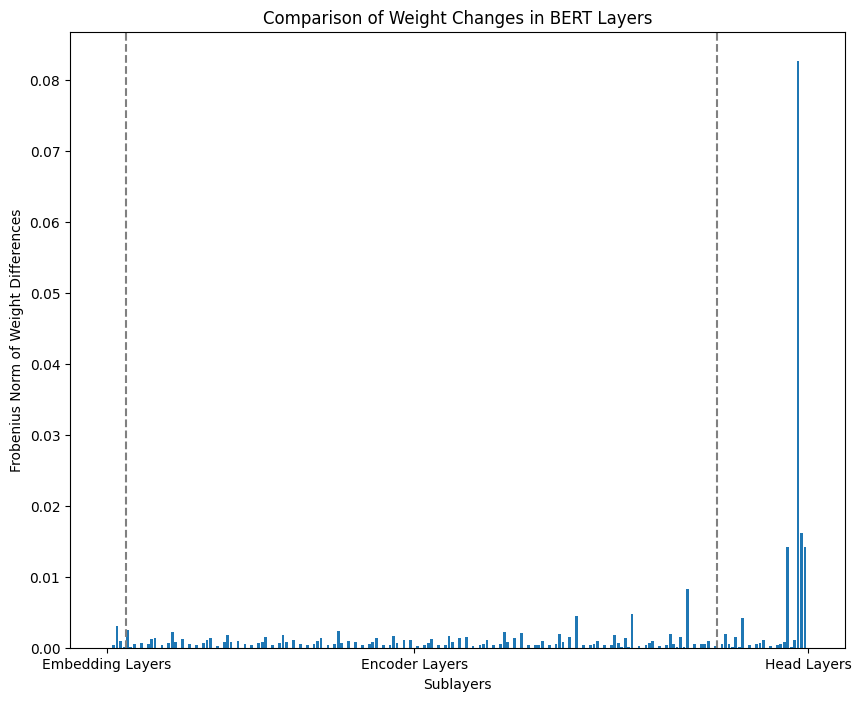

In [18]:
# Comparaison of weights for different model
import numpy as np

weights_kb = comprehension_model.get_model_weights(model_kb)
weights_finetuned = comprehension_model.get_model_weights(model_hugging_face)

weight_diffs = {}
for key in weights_kb.keys():
    weight_diffs[key] = weights_finetuned[key] - weights_kb[key]
    if (np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) > 0.04 :
        print(key)
    #     print(np.linalg.norm(weight_diffs[key],2))
    #     print(weight_diffs[key].size)
    #     print( np.linalg.norm(weight_diffs[key])/weight_diffs[key].size)
    

weight_diffs["cls.predictions.decoder.bias"] = model_hugging_face.cls.predictions.decoder.bias.detach().cpu().numpy() - model_kb.cls.predictions.decoder.bias.detach().cpu().numpy()
weight_diffs["cls.predictions.decoder.weight"] = model_hugging_face.cls.predictions.decoder.weight.detach().cpu().numpy() - model_kb.cls.predictions.decoder.weight.detach().cpu().numpy()
norms = [(np.linalg.norm(weight_diffs[key])/weight_diffs[key].size) for key in weight_diffs.keys()]
embedding_indices = [list(range(0, 5))]
encoder_layers= list(range(5 ,5 +16*(11)))  # Adjust based on actual sublayers
head_layer_indices = list(range(181, len(norms)))

xticks_positions = [0, len(encoder_layers)//2 + len(embedding_indices), len(norms)-1]
xticks_labels = ['Embedding Layers', 'Encoder Layers', 'Head Layers']

plt.figure(figsize=(10, 8))
plt.bar(range(len(norms)), norms)
plt.axvline(x=5.5, color='grey', linestyle='--')
plt.axvline(x=len(embedding_indices) + len(encoder_layers) - 0.5, color='grey', linestyle='--')
plt.xticks(xticks_positions, xticks_labels, rotation=0)
plt.ylabel('Frobenius Norm of Weight Differences')
plt.xlabel('Sublayers')
plt.title('Comparison of Weight Changes in BERT Layers')
plt.show()  

In [ ]:
model_hugging_face.state_dict()["bert.encoder.layer.0.attention.self.key.weight"].shape

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('weight_distribution_scratch.pdf') as pdf:
    for name,param in mosaicBert.named_parameters():
        layer_name = name
        print(name)
        split_name =name.split('.')
        layer = split_name[3]
        print(layer)
        #comprehension_model.plot_weight_distributions(model_hugging_face, model_kb, layer_name)
        if "attention.self.Wqkv"  in name and "weight" in name:
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.query.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][:768,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.key.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][768:1536,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.value.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][1536:,:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
        elif  "attention.self.Wqkv" in name and "bias" in name :
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.query.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][:768].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.key.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][768:1536].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.attention.self.value.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name][1536:].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close() 
        elif "mlp.gated_layers"  in name :
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.intermediate.dense.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "mlp.wo" in name :
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.output.dense.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "mlp.layernorm"  in name :
            
            weights2 = model_kb.state_dict()[f"bert.encoder.layer.{str(layer)}.output.LayerNorm.{split_name[-1]}"].flatten().cpu().numpy()
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()
            
        elif "cls.predictions.decoder" in name:
            continue
            
        else :
            weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
            weights2 = model_kb.state_dict()[layer_name].flatten().cpu().numpy()
            plt.figure(figsize=(10, 5))
            plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
            plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
            plt.title(f"Weight Distribution Comparison for {layer_name}")
            plt.xlabel("Weight values")
            plt.ylabel("Frequency")
            plt.legend()
            pdf.savefig()
            plt.show()
            plt.close()

In [ ]:
for name,param in model_exbert.named_parameters():
    print(name)

In [ ]:

layer_name = "cls.predictions.transform.dense.weight"

weights2 = model_kb.state_dict()[layer_name].flatten().cpu().numpy()
weights1 = mosaicBert.state_dict()[layer_name].flatten().cpu().numpy()
plt.figure(figsize=(10, 5))
plt.hist(weights1, bins=100, alpha=0.5, label='finetuned Model',density=True)
plt.hist(weights2, bins=100, alpha=0.5, label='Baseline Model',density=True)
plt.title(f"Weight Distribution Comparison for {layer_name} for SparBERT")
plt.xlabel("Weight values")
plt.ylabel("Frequency")
plt.legend()
plt.show()
plt.close()

In [ ]:
import torch.nn.functional as F
print(hidden_states1[0].shape)
i=8
hidden_states1,logits1=get_embeddings_bis(model_kb,valid_sentence_filtered [i],tokenizer)
hidden_states2,logits2=get_embeddings_bis(model_hugging_face,valid_sentence_filtered [i],tokenizer)
#masked_positions =[idx for idx, token in enumerate(valid_filtered_dataset[i]['input_ids']) if token == tokenizer.mask_token_id]
index = valid_sentence_filtered [i]['labels'].index(token_id)
print(token_id)
print(tokenizer.decode(valid_sentence_filtered[i]['input_ids']))
print(tokenizer.decode(torch.argmax(F.softmax(logits1.squeeze()[index], dim=-1)).item()))
print(tokenizer.decode(torch.argmax(F.softmax(logits2.squeeze()[index], dim=-1)).item()))
for j in range(len(hidden_states1)) :
    print(tokenizer.decode((valid_sentence_filtered[i]['labels'][index])))
    print('hidden layer ',j)
    plt.figure(figsize=(10,6))
   #plt.hist(hidden_states1[j][0][index].detach().cpu().numpy(), bins=100, alpha=0.5, label='Baseline Model')
    plt.hist(hidden_states1[j][0][0].detach().cpu().numpy(), bins=100, alpha=0.5, label='Baseline Model cls')
    #plt.hist(hidden_states2[j][0][index].detach().cpu().numpy(), bins=100, alpha=0.5, label='Fine-tuned Model')
    plt.hist(hidden_states2[j][0][0].detach().cpu().numpy(), bins=100, alpha=0.5, label='finetuned Model cls')
    plt.xlabel('weight')
    plt.ylabel('frequency')
    plt.legend()
    plt.show()

In [ ]:
import numpy as np 
checkpoint_directory = "/home/laurinemeier/swerick/finetuning/finetuning_hugging_whitespace-finetuned-imdb"
checkpoint_files = os.listdir(checkpoint_directory)
checkpoint_files.sort(key=lambda x: int(re.search(r'checkpoint-(\d+)', x).group(1)))
selected_checkpoints = [checkpoint_files[i] for i in range(0, len(checkpoint_files), 10)]
weight1 = model_kb.state_dict()["bert.embeddings.word_embeddings.weight"].flatten().cpu().numpy()
print("std kb", np.std(weight1))
for name in selected_checkpoints :
    print(name)
    model_hugging =AutoModelForMaskedLM.from_pretrained(checkpoint_directory + '/'+name)
    weights2 = model_hugging.state_dict()["bert.embeddings.word_embeddings.weight"].flatten().cpu().numpy()
    print(np.std(weights2))
    model_hugging.to(device)
    comprehension_model.plot_weight_distributions(model_hugging, model_kb, "bert.embeddings.word_embeddings.weight")

In [ ]:
hidden_states1 = comprehension_model.get_embeddings(model_kb, small_valid_dataloader, tokenizer)
hidden_states2 = comprehension_model.get_embeddings(model_hugging_face, small_valid_dataloader, tokenizer)

for i in range(len(hidden_states1)):
        plt.figure(figsize=(10, 5))
        plt.hist(hidden_states1[i].flatten(), bins=100, alpha=0.5, label='Baseline Model')
        plt.hist(hidden_states2[i].flatten(), bins=100, alpha=0.5, label='Fine-tuned Model')
        plt.title(f"Hidden States Distribution Comparison for Layer {i}")
        plt.xlabel("Hidden States Values")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

In [ ]:
#Evolution of a specific layer through epochs
checkpoint_directory = 'finetuning/finetuning_hugging_whitespace-finetuned-imdb'
comprehension_model.evolution_specific_layer_weight(chekpoint_directory)

Study of Word Embedding

In [ ]:

def plot_results(mean_similarities,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(mean_similarities)), mean_similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_hidden_states,mean_similarities_attention,diff_tot = comprehension_model.extract_and_compare_activations(model_kb, model_hugging_face, valid_filtered_dataloader,token_id)
print("Layer-wise cosine similarities:", mean_similarities_hidden_states)


plot_results(mean_similarities_hidden_states)
plot_results(mean_similarities_attention,'Attention Layer Number',title='Average Attention Layer-wise Cosine Similarity between Attention values Across Validation Dataset')
plot_results(diff_tot,'Layer Number',title='Average Norm difference between hidden states  Across Validation Dataset for token {words}')



In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt


def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()


# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def plot_results(similarities, x_label='Layer Number', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

def compare_ffn_contributions(model_pre, model_post, dataloader):
    similarities_pre = []
   #similarities_post = []
    
    for batch in dataloader:
        batch = {k: batch[k].to(device) for k in batch.keys()}
        
        with torch.no_grad():
            pre_output = model_pre(**batch, output_hidden_states=True)
            pre_activations = pre_output.hidden_states
            post_output = model_post(**batch, output_hidden_states=True)
            post_activations = post_output.hidden_states
    
        pre_contribution = [(pre_activations[layer+1] -pre_activations[layer]) for layer in range(len(pre_activations)-1)]
        post_contribution = [(post_activations[layer+1] - post_activations[layer]) for layer in range(len(post_activations)-1)]

        pre_activation = [cosine_similarity(pre_contribution[i],post_contribution[i]) for i in range (len(pre_contribution))]
       # post_activation = [cosine_similairity(post_contribution[i] for i in range (len(post_contribution)))]
        similarities_pre.append(pre_activation)
       # similarities_post.append(post_contribution)
        
        del pre_activations
        del post_activations
        del pre_output
        del post_output
    
    similarities_pre = np.mean(np.array(similarities_pre), axis=0)
   # similarities_post = np.mean(np.array(similarities_post), axis=0)
    
    return similarities_pre
# Example usage
mean_similarity_pr = compare_ffn_contributions(model_kb, model_hugging_face, small_valid_dataloader)

plot_results(mean_similarity_pr, x_label='Layer n+1 - Layer n', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity for differences consecutive layers of KB Bert Model and cptBERT')
#plot_results(mean_similarity_post, label='Layer n+1 - Layer n', x_label='Layer n+1 - Layer n', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity for Finetuned Model')


In [ ]:
import torch.nn.functional as F
import numpy as np

# see if final layers is similar


def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()


def interpolate_to_length(tensor, target_length):
    # Interpolation linéaire pour redimensionner le tenseur à la longueur cible
    current_length = tensor.shape[1]
    if current_length == target_length:
        return tensor
    # Créer un tenseur avec la longueur cible en utilisant l'interpolation linéaire
    interpolated_tensor = F.interpolate(tensor.transpose(1, 2), size=target_length, mode='linear', align_corners=False).transpose(1, 2)
    return interpolated_tensor

def plot_results(similarities, x_label='Layer Number', y_label='Average Cosine Similarity', title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()
    
model_hugging_face.to(device)
model_exbert.to(device)
#mosaicBert.to(device)  
model_kb.to(device)




cosine_cpt_final=[]
cosine_eb_final=[]
cosine_spa_final=[]
hidden_states=[]
cosine_embedding=[]
diff_final_kb=[]
diff_final_eb=[]
embedding_cpt = model_hugging_face.bert.embeddings
embedding_kb=model_kb.bert.embeddings

# random_vector = torch.randn_like(hidden_states[0]).to(device)
torch.manual_seed(33)
for layer in range(12):

    cosine_cpt=[]
    cosine_eb=[]
    cosine_spa=[]
    diff_kb=[]
    diff_eb=[]
    last_layer_kb = model_kb.bert.encoder.layer[layer]
    last_layer_cpt = model_hugging_face.bert.encoder.layer[layer]
    last_layer_eb=model_exbert.bert.encoder.layer[layer]
       
    for batch in small_valid_dataloader :
        batch={key:value.to(device) for key,value in batch.items()}
        with torch.no_grad():
            output=model_kb(**batch,output_hidden_states=True)
        if layer ==0:
            embedding = embedding_cpt(batch["input_ids"])
            
        hidden_states=output.hidden_states[layer].to(device)

      
        # if layer ==0:
        #     embedding = embedding_cpt(random_embedding)  
        #     embeddingkb= embedding_kb(random_embedding)
        hs_kb=last_layer_kb(hidden_states)
        hs_cpt=last_layer_cpt(hidden_states)
        hs_eb=last_layer_eb(hidden_states)
        
        
                
        # if layer==0:
        #     cosine_embedding.append(cosine_similarity(embeddingkb,embedding))
            
        cosine_cpt.append(cosine_similarity(hs_kb[0],hs_cpt[0]))
        cosine_eb.append(cosine_similarity(hs_kb[0],hs_eb[0]))
        cosine_spa.append(cosine_similarity(hs_eb[0],hs_cpt[0]))
        diff_kb.append(cosine_similarity(hs_kb[0]-hidden_states,hs_cpt[0]-hidden_states))
        diff_eb.append(cosine_similarity(hs_kb[0]-hidden_states,hs_eb[0]-hidden_states))
        # if layer==0:
        #     cosine_cpt_final.append(np.mean(cosine_embedding))
    cosine_cpt_final.append(np.mean(cosine_cpt))
    cosine_eb_final.append(np.mean(cosine_eb))
    cosine_spa_final.append(np.mean(cosine_spa,axis=0))
    diff_final_kb.append(np.mean(diff_kb))
    diff_final_eb.append(np.mean(diff_eb))
    
    print(np.mean(cosine_cpt))
    print(np.mean(cosine_eb))   
            

plot_results(cosine_cpt_final,x_label='Layer',title='Avg cosine similarity between KB bert and cptBERT without propagation')
plot_results(cosine_eb_final,x_label='Layer',title='Avg cosine similarity between KB bert and sBERTex without propagation')
plot_results(cosine_spa_final,x_label='Layer',title='Avg cosine similarity between cptBERT and sBERTex without propagation')
plot_results(diff_final_kb,x_label='Layer',title='Avg cosine similarity between differences of consecutives layers cptBERT and KB bert without propagation')
plot_results(diff_final_eb,x_label='Layer',title='Avg cosine similarity between differences of consecutives layers sBERTex and KB bert without propagation')
# # print("cosine similarity spa",np.mean(cosine_spa,axis=0))
    
# sentence = "Herr [MASK] von Ehrenheim : Äfven"
# input_kb=tokenizer(sentence,return_tensors='pt').to(device)
# input_eb=exbert_tokenizer(sentence,return_tensors='pt').to(device)
# model_kb.to(device)
# model_exbert.to(device)


# output1=model_kb(**input_kb,output_hidden_states=True)
# output2=model_exbert(**input_eb,output_hidden_states=True)
# pre_activations = output1.hidden_states
# post_activation=output2.hidden_states

# target_length=len(pre_activations[0][0])
# print(target_length)

# pre_contribution = [interpolate_to_length((pre_activations[layer+1] -pre_activations[layer]),target_length) for layer in range(len(pre_activations)-1)]
# post_contribution = [interpolate_to_length((post_activation[layer+1] - post_activation[layer]),target_length) for layer in range(len(post_activation)-1)]

# cosine_activation = [cosine_similarity(pre_contribution[i],post_contribution[i]) for i in range (len(pre_contribution))]


# plot_results(cosine_activation,x_label="Layer",y_label="Average Cosine Similairyt difference")






In [ ]:
import torch.nn.functional as F

text="Herr [MASK] von Ehrenheim : Anledningen till den framställning"
input_kb=tokenizer(text,return_tensors='pt').to(device)
output=model_kb(**input_kb,output_hidden_states=True)

hidden_states=output.hidden_states[-1].to(device)
head_layer_kb=model_kb.cls
head_layer_cpt=model_hugging_face.cls
head_layer_eb=model_exbert.cls
head_layer_spa=mosaicBert.cls
output_kb = head_layer_kb(hidden_states)
output_cpt = head_layer_cpt(hidden_states)
output_eb = head_layer_eb(hidden_states)
output_spa=head_layer_spa(hidden_states)
print(output_kb.shape)

softmax_probs_kb = F.softmax(output_kb.squeeze()[2], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
print(sorted_tokens_kb)

softmax_probs_kb = F.softmax(output.logits.squeeze()[2], dim=-1)
sorted_probs_kb, sorted_indices_kb = torch.sort(softmax_probs_kb, descending=True)
sorted_tokens_kb = [tokenizer.decode([idx]) for idx in sorted_indices_kb[:10]]
print(sorted_tokens_kb)

softmax_probs_cpt = F.softmax(output_cpt.squeeze()[2], dim=-1)
sorted_probs_cpt, sorted_indices_cpt = torch.sort(softmax_probs_cpt, descending=True)
sorted_tokens_cpt= [tokenizer.decode([idx]) for idx in sorted_indices_cpt[:10]]
print(sorted_tokens_cpt)

softmax_probs_eb = F.softmax(output_eb.squeeze()[2], dim=-1)
sorted_probs_eb, sorted_indices_eb = torch.sort(softmax_probs_eb, descending=True)
sorted_tokens_eb = [exbert_tokenizer.decode([idx]) for idx in sorted_indices_eb[:10]]
print(sorted_tokens_eb)


softmax_probs_spa = F.softmax(output_spa.squeeze()[2], dim=-1)
sorted_probs_spa, sorted_indices_spa = torch.sort(softmax_probs_spa, descending=True)
sorted_tokens_spa = [swerick_tokenizer.decode([idx]) for idx in sorted_indices_spa[:10]]
print(sorted_tokens_spa)

In [ ]:
# Cosine similarity between layers
from datasets import Dataset
import torch
import numpy as np




def extract_and_compare_feed_forward_weights(model_pre, model_post, dataloader):
    similarities_attention = {}
    similarities_query = {}
    similarities_key = {}
    similarities_value = {}
    for (name_base, param_base), (name_fine, param_fine) in zip(model_kb.named_parameters(), model_hugging_face.named_parameters()):
        if "cls.predictions.transform.dense.weight" in name_base :
            sim = cosine_similarity(param_base, param_fine)
            similarities_attention[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")
        if  "cls.predictions.transform.dense.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_query[name_base]=sim
        if  "attention.self.key.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_key[name_base]=sim
        if  "attention.self.value.bias" in name_base:
            sim = cosine_similarity(param_base, param_fine)
            similarities_value[name_base]=sim
            print(f"{name_base} - Cosine Similarity: {sim}")

    return similarities_attention,similarities_query,similarities_key,similarities_value
       
def cosine_similarity(tensor1, tensor2):
    # Ensure tensors are flattened (1D) to compute vector cosine similarity
    tensor1_flat = tensor1.view(-1)
    tensor2_flat = tensor2.view(-1)
    cos_sim = torch.nn.functional.cosine_similarity(tensor1_flat.unsqueeze(0), tensor2_flat.unsqueeze(0))
    return cos_sim.item()



def plot_results(similarities,label,x_label='Layer Number',y_label='Average Cosine Similarity',title='Average Layer-wise Cosine Similarity between hidden_states Across Validation Dataset'):
    plt.figure(figsize=(10, 5))
    plt.plot(range(len(similarities)), similarities, marker='o', linestyle='-', color='b',)
    plt.xlabel(label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

mean_similarities_attention,mean_similarities_query,mean_similarities_key,mean_similarities_value = extract_and_compare_feed_forward_weights(model_kb, model_hugging_face, valid_dataloader)
similarity_attention=[mean_similarities_attention[i] for i in mean_similarities_attention.keys()]
similarity_query=[mean_similarities_query[i] for i in mean_similarities_query.keys()]
similarity_key=[mean_similarities_key[i] for i in mean_similarities_key.keys()]
similarity_value=[mean_similarities_value[i] for i in mean_similarities_value.keys()]



plot_results(similarity_attention,label = mean_similarities_attention.keys(),title='layer wise cosine similarity between weights for attention.output.dense')
plot_results(similarity_query,label = mean_similarities_query.keys(),title='layer wise cosine similarity between weights for attention.self.query')
plot_results(similarity_key,label = mean_similarities_key.keys(),title='layer wise cosine similarity between weights for attention.self.key')
plot_results(similarity_value,label = mean_similarities_value.keys(),title='layer wise cosine similarity between weights for attention.self.value')


In [ ]:
def get_embeddings(text,model):

    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs,output_hidden_states=True)
        
    embeddings = outputs.hidden_states
    return embeddings

In [ ]:
embeddings_train = [get_embeddings(phrase,model_kb) for phrase in date_dataset["train"]["content"][:5]]
print(len(embeddings_train))
print(len(embeddings_train[0]))
embeddings_test = [get_embeddings(phrase,model_kb) for phrase in date_dataset["test"]["content"][:5]]

In [ ]:
#Edge probing : predicting noun  
import numpy as np 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
        
def extract_and_classify(dataset, model,length):
    layer_accuracies = []
    with torch.no_grad():
        for layer_index in range(model.config.num_hidden_layers + 1):  # Include the embedding layer
            embeddings_train = [get_embeddings(phrase,model_kb) for phrase in dataset["train"]["content"][:length]]
            train_embeddings =[sentence[layer_index] for sentence in embeddings_train] 
            train_labels = date_dataset["train"]["reform_label"][:length]
            print(train_embeddings)
            print(len(train_labels))
            embeddings_test = [get_embeddings(phrase,model_kb) for phrase in dataset["test"]["content"][:length]]
            test_embeddings =[sentence[layer_index] for sentence in embeddings_test] 
            testlabels = date_dataset["test"]["reform_label"][:length]
    
            clf = LogisticRegression()
            clf.fit(train_embeddings, train_labels)
            y_pred = clf.predict(test_embeddings)

            # Calculate accuracy
            accuracy = accuracy_score(test_labels, y_pred)
            layer_accuracies.append((layer_index, accuracy))
    
    return layer_accuracies


accuracies = extract_and_classify(date_dataset, model_kb,5)

# Output the accuracies for each layer
for layer, acc in accuracies:
    print(f"Layer {layer}: Accuracy {acc}")




In [ ]:
train_embeddings =[sentence[1] for sentence in embeddings_train] 
len(train_embeddings[0][0][0])

In [ ]:
input = date_dataset["train"]["content"][0]
input = tokenizer(input,return_tensors="pt", padding="max_length", truncation=True, max_length=512)
data_collator = preprocessing.data_collector_masking(tokenizer,0.15)
input=data_collator([input])
collated_inputs = {key: value.squeeze(1) for key, value in input.items()}
output =model_kb(collated_inputs["input_ids"],attention_mask=collated_inputs["attention_mask"],labels =collated_inputs["labels"],output_hidden_states=True)
hidden_states = output.hidden_states



In [ ]:
def extract_features(examples,model):
  # take a batch of images
  images = examples['content']
  images = tokenizer(images,return_tensors="pt", padding="max_length", truncation=True, max_length=512)
  input=data_collator([images])
  collated_inputs = {key: value.squeeze(1) for key, value in input.items()}
  with torch.no_grad():
    output =model(collated_inputs["input_ids"],attention_mask=collated_inputs["attention_mask"],labels =collated_inputs["labels"],output_hidden_states=True)
  hidden_states = output.hidden_states
  # add features of each layer
  for i in range(len(hidden_states)):
      features = torch.mean(hidden_states[i], dim=1)
      examples[f'features_{i}'] = features.cpu().detach().numpy()
  
  return examples

In [ ]:
encoded_dataset_train_bis=Dataset.from_dict(date_dataset["train"][100:150]).map(lambda example :extract_features(example,model_hugging_face), batched=False)

In [ ]:
encoded_dataset_test_bis = Dataset.from_dict(date_dataset["test"][:100]).map(lambda example :extract_features(example,model_hugging_face), batched=False)

In [ ]:
encoded_dataset_test['features_4']==encoded_dataset_test_bis['features_4']

In [ ]:
from sklearn.linear_model import LogisticRegression
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score
def scores_linear_prob(train_dataset,test_dataset):
    train_dataset = train_dataset
    test_dataset = test_dataset

    scores = dict()
    for i in range(model_kb.config.num_hidden_layers + 1):
        train_features = torch.Tensor(train_dataset[f'features_{i}']).squeeze(1)
        test_features = torch.Tensor(test_dataset[f'features_{i}']).squeeze(1)
        lr_clf = LogisticRegression()
        lr_clf.fit(train_features, train_dataset['reform_label'])
        # compute accuracy on training + test set
        #training_score = lr_clf.score(train_features, train_dataset['reform_label'])
        #test_score = lr_clf.score(test_features, test_dataset['reform_label'])
        #scores[f'features_{i}'] = (training_score, test_score)

        train_preds = lr_clf.predict(train_features)
        test_preds = lr_clf.predict(test_features)
        training_f1 = f1_score(train_dataset['reform_label'], train_preds, average='macro')
        test_f1 = f1_score(test_dataset['reform_label'], test_preds, average='macro')
        
        scores[f'features_{i}'] = (training_f1, test_f1)
        
    return scores
